In [2]:
import torch
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import numpy as np


In [1]:
!pip install -q transformers datasets accelerate


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: cuda


In [5]:
MODEL_NAME = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
model.to(device)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2026-02-05 17:28:23.734833: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770312503.909948      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770312503.959501      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770312504.411577      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770312504.411623      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770312504.411626      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [6]:
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

tokenized = dataset.map(tokenize, batched=True, remove_columns=["text"])
tokenized.set_format("torch")

train_dataset = tokenized["train"]


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True
)


In [8]:
LOG_EVERY = 200

grad_logs = {}

for name, param in model.named_parameters():
    if param.requires_grad:
        grad_logs[name] = []

TRACK_LAYERS = [
    "transformer.h.0",
    "transformer.h.2",
    "transformer.h.4"
]

grad_logs = {
    name: [] for name in grad_logs
    if any(layer in name for layer in TRACK_LAYERS)
}

PROJ_DIM = 256

projections = {}

for name in grad_logs:
    size = model.state_dict()[name].numel()
    projections[name] = torch.randn(size, device=device)


In [10]:

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


In [11]:
EPOCHS = 1
global_step = 0

model.train()

for epoch in range(EPOCHS):
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in loop:
        
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=input_ids
        )
        
        loss = outputs.loss
        loss.backward()

        if global_step % LOG_EVERY == 0:
            
            for name, param in model.named_parameters():
                
                if name not in grad_logs:
                    continue
                
                if param.grad is None:
                    continue
                
                g = param.grad.detach().flatten()
                
                proj = torch.dot(g, projections[name]).item()
                norm = torch.norm(g).item()
                
                grad_logs[name].append({
                    "step": global_step,
                    "norm": norm,
                    "proj": proj
                })
        
        optimizer.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        
        global_step += 1
        
        loop.set_postfix(loss=loss.item())


Epoch 1: 100%|██████████| 9180/9180 [11:18<00:00, 13.54it/s, loss=1.28]    


In [12]:
os.makedirs("logs", exist_ok=True)

torch.save(grad_logs, "logs/grad_logs.pt")

print("Gradient logs saved to logs/grad_logs.pt")


Gradient logs saved to logs/grad_logs.pt


In [14]:
import torch

grad_logs = torch.load("logs/grad_logs.pt")

print("Loaded keys (layers):")
for k in grad_logs.keys():
    print(k)


Loaded keys (layers):
transformer.h.0.ln_1.weight
transformer.h.0.ln_1.bias
transformer.h.0.attn.c_attn.weight
transformer.h.0.attn.c_attn.bias
transformer.h.0.attn.c_proj.weight
transformer.h.0.attn.c_proj.bias
transformer.h.0.ln_2.weight
transformer.h.0.ln_2.bias
transformer.h.0.mlp.c_fc.weight
transformer.h.0.mlp.c_fc.bias
transformer.h.0.mlp.c_proj.weight
transformer.h.0.mlp.c_proj.bias
transformer.h.2.ln_1.weight
transformer.h.2.ln_1.bias
transformer.h.2.attn.c_attn.weight
transformer.h.2.attn.c_attn.bias
transformer.h.2.attn.c_proj.weight
transformer.h.2.attn.c_proj.bias
transformer.h.2.ln_2.weight
transformer.h.2.ln_2.bias
transformer.h.2.mlp.c_fc.weight
transformer.h.2.mlp.c_fc.bias
transformer.h.2.mlp.c_proj.weight
transformer.h.2.mlp.c_proj.bias
transformer.h.4.ln_1.weight
transformer.h.4.ln_1.bias
transformer.h.4.attn.c_attn.weight
transformer.h.4.attn.c_attn.bias
transformer.h.4.attn.c_proj.weight
transformer.h.4.attn.c_proj.bias
transformer.h.4.ln_2.weight
transformer.h.4.

In [15]:

layer_name = list(grad_logs.keys())[0]

print("Layer:", layer_name)
print("Number of logged steps:", len(grad_logs[layer_name]))

print("First record:")
print(grad_logs[layer_name][0])


Layer: transformer.h.0.ln_1.weight
Number of logged steps: 47
First record:
{'step': 0, 'norm': 1.303037405014038, 'proj': -0.011347249150276184}


In [16]:
import numpy as np

layer_data = {}

for layer, records in grad_logs.items():
    
    steps = []
    norms = []
    projs = []
    
    for r in records:
        steps.append(r["step"])
        norms.append(r["norm"])
        projs.append(r["proj"])
    
    layer_data[layer] = {
        "steps": np.array(steps),
        "norms": np.array(norms),
        "projs": np.array(projs)
    }

print("Prepared data for", len(layer_data), "layers")


Prepared data for 36 layers


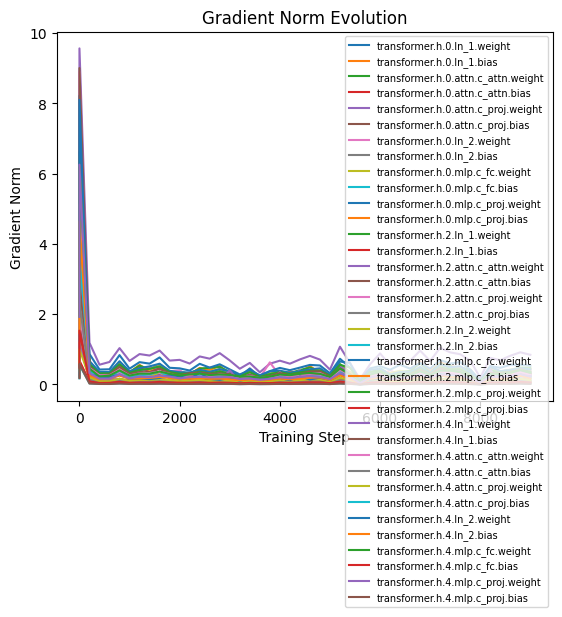

In [17]:
import matplotlib.pyplot as plt

plt.figure()

for layer, data in layer_data.items():
    plt.plot(data["steps"], data["norms"], label=layer)

plt.xlabel("Training Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norm Evolution")

plt.legend(fontsize=7)
plt.show()


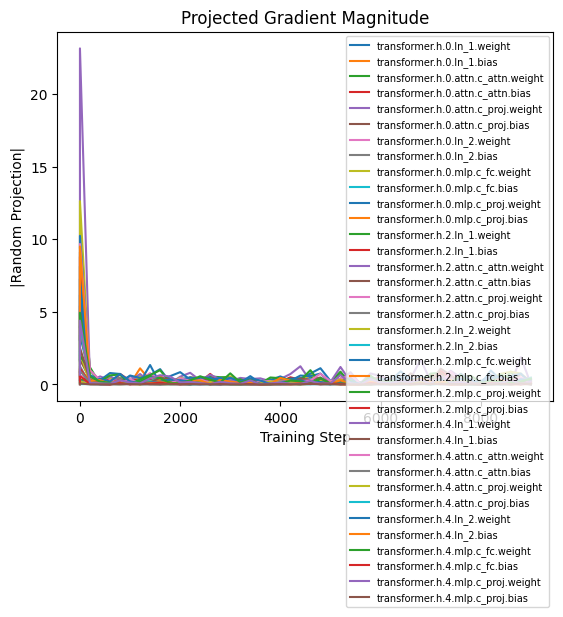

In [18]:
plt.figure()

for layer, data in layer_data.items():
    plt.plot(data["steps"], np.abs(data["projs"]), label=layer)

plt.xlabel("Training Step")
plt.ylabel("|Random Projection|")
plt.title("Projected Gradient Magnitude")

plt.legend(fontsize=7)
plt.show()


In [19]:
for layer, data in layer_data.items():
    
    var = np.var(data["projs"])
    mean_norm = np.mean(data["norms"])
    
    print(f"{layer[:40]}...")
    print(f"  Projection variance: {var:.4f}")
    print(f"  Mean norm: {mean_norm:.4f}")


transformer.h.0.ln_1.weight...
  Projection variance: 0.2986
  Mean norm: 0.3365
transformer.h.0.ln_1.bias...
  Projection variance: 0.5022
  Mean norm: 0.4948
transformer.h.0.attn.c_attn.weight...
  Projection variance: 1.5922
  Mean norm: 0.5401
transformer.h.0.attn.c_attn.bias...
  Projection variance: 0.7791
  Mean norm: 0.3216
transformer.h.0.attn.c_proj.weight...
  Projection variance: 12.9374
  Mean norm: 0.9633
transformer.h.0.attn.c_proj.bias...
  Projection variance: 0.1292
  Mean norm: 0.2961
transformer.h.0.ln_2.weight...
  Projection variance: 0.0916
  Mean norm: 0.5650
transformer.h.0.ln_2.bias...
  Projection variance: 1.8987
  Mean norm: 0.3814
transformer.h.0.mlp.c_fc.weight...
  Projection variance: 3.7286
  Mean norm: 0.5053
transformer.h.0.mlp.c_fc.bias...
  Projection variance: 0.0073
  Mean norm: 0.1195
transformer.h.0.mlp.c_proj.weight...
  Projection variance: 2.6856
  Mean norm: 0.6716
transformer.h.0.mlp.c_proj.bias...
  Projection variance: 0.0022
  Mean norm

In [20]:
torch.save(layer_data, "logs/processed_grad_data.pt")